Here's an example of data generation and simple inference, which is simply gradient based optimization. 

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import numpy as np
import math 
import time
import torch
import torch.optim as optim
from torch.distributions import Beta, Bernoulli
from torch.nn.functional import softmax, log_softmax
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from abc import ABC, abstractmethod

### Generation:

In [2]:
### these params control the generation scheme
rho = 0.8
pop_size = 5000
epsilon = 0.05
pi = 0.5
speech_len = 15

def generate(rho=rho, N=pop_size, epsilon=epsilon, pi=pi, speech_len=15):
    ### we specify a mean of one of the modes rho
    ### fix a way to get variance sigma from rho
    ### then solve the system to get alpha, beta for beta distribution
    sigma = 0.175 * (rho ** 2) - 0.3625 * rho + 0.1875
    a = rho * ((rho * (1 - rho)) / sigma - 1)
    b = (1 - rho) * ((rho * (1 - rho)) / sigma - 1)

    ### beta mixture model
    weights = [pi, 1-pi]
    mixture_samples = np.random.choice([0, 1], size=N, p=weights)
    u = 2 * np.where(mixture_samples == 0, stats.beta.rvs(a, b, size=N), stats.beta.rvs(b, a, size=N)) - 1

    ### y deterministic given u
    y = (u >= 0).astype(int)
    
    ### left, right, neutral
    phi = [(1 - (u+1)/2) * (1 - epsilon), (u+1)/2 * (1 - epsilon), np.repeat(epsilon, N)]
    prob_matrix = np.vstack(phi).T 
    ### x ~ Multinomial(S, phi)
    X = np.array([stats.multinomial.rvs(n=speech_len, p=prob_matrix[i, :]) for i in range(N)])
    known   = (y, X)
    unknown = (a, b, epsilon, u)
    
    return known, unknown


known, unknown = generate()

a, b, e, u = unknown
y, X = known
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
print(f"True Alpha: {a}")
print(f"True Beta: {b}")
print(f"True Epsilon: {e}")

True Alpha: 12.673684210526261
True Beta: 3.1684210526315644
True Epsilon: 0.05


In [3]:
print(f"y examples:\n {y[:5]}\n {'='*10}")
print(f'X examples:\n {X[:5]}')

y examples:
 tensor([0., 1., 0., 0., 0.])
X examples:
 tensor([[12.,  2.,  1.],
        [ 0., 15.,  0.],
        [10.,  4.,  1.],
        [13.,  2.,  0.],
        [ 8.,  6.,  1.]])


Our goal now is to infer $\hat{u}^{(i)}$ for each $(x^{(i)}, y^{(i)})$ pair. At a high level, we first need to learn the parameters $\theta$, which include for example $\alpha, \beta$, and then use these parameters to infer $\hat{u}^{(i)}$. For the first step, we will maximize the log marginal likelihood, and for the second step we will maximize the joint w.r.t $u$ with these trained parameters.

Our posterior is intractable, though approximable by discretizing the integral. In other words, we'll assume we can take the gradient but cannot directly argmax. Thus, we'll begin with simple gradient based optimization.

In [52]:
class GradientDescent(ABC):
    def __init__(
        self, 
        X, 
        y, 
        log_alpha0  = torch.tensor(1.5, requires_grad=True),
        log_beta0   = torch.tensor(0.7, requires_grad=True),
        W0          = torch.tensor([-2.0, 2.0, 0.0], requires_grad=True),
        num_epochs  = 200,
        batch_size  = 100,
        approx_size = 25,
        grid_size   = 100
        ):
        self.X = X
        self.y = y
        self.dataset    = TensorDataset(X, y)
        self.dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        self.num_epochs  = num_epochs
        self.batch_size  = batch_size
        self.approx_size = approx_size
        self.grid_size   = grid_size

        self.log_alpha   = log_alpha0
        self.log_beta    = log_beta0
        self.W           = W0

        self.log_alpha0  = log_alpha0 
        self.log_beta0   = log_beta0 
        self.W0          = W0

        self.optimizer   = Adam([self.log_alpha, self.log_beta, self.W])
        self.delta       = 1e-5

    @abstractmethod
    def joint_log_prob(self, u, x_n, y_n):
        """
        u.size() == [batch_size, approx_size]
        x_n.size() == [batch_size, 3]
        y_n.size() == [batch_size]

        Computes log p(u, x_n, y_n; theta) (sometimes averaging sometimes returns a matrix)
        """
        pass

    @abstractmethod
    def sample_posterior(self, x_n, y_n):
        """
        Samples u ~ p(u | x_n, y_n; theta)
        """
        raise NotImplementedError

    def initialize(self):
        self.log_alpha = self.log_alpha0 
        self.log_beta  = self.log_beta0 
        self.W         = self.W0

    def train(self):
        self.initialize() 
        start = time.time()
        for epoch in range(self.num_epochs):
            print(f'Beginning Epoch {epoch+1} of {self.num_epochs}')
            total_loss = 0.0
            for x_batch, y_batch in self.dataloader:
                self.optimizer.zero_grad()
                u_batch    = self.sample_posterior(x_batch, y_batch) 
                batch_loss = -self.joint_log_prob(u_batch, x_batch, y_batch) 
                batch_loss.backward()
                self.optimizer.step()
                total_loss += batch_loss.item() * x_batch.size(0)

            total_loss /= len(self.dataloader.dataset)
            print(f'Epoch {epoch+1}: Alpha: {torch.exp(self.log_alpha).item()}, Beta: {torch.exp(self.log_beta).item()}, W: {self.W.data}, Loss: {total_loss}')
            print('=' * 20)

        final_alpha = torch.exp(self.log_alpha).item()
        final_beta = torch.exp(self.log_beta).item()
        print(f"Training Took {round(time.time() - start, 2)} Seconds.")
        print(f"Trained Params: alpha: {max(final_alpha, final_beta)}, beta: {min(final_alpha, final_beta)}, W: {self.W.data}")

In [53]:
class VectorGradientDescent(GradientDescent):
    """
    Vectorized gradient descent
        - Computes joint log via its closed form
        - Computes posterior by discretizing the integral
    """

    def joint_log_prob(self, u, x_n, y_n, average=True):
        alpha = torch.exp(self.log_alpha)
        beta  = torch.exp(self.log_beta)
        
        beta_dist_ab = Beta(alpha, beta)
        beta_dist_ba = Beta(beta, alpha)

        # Compute log probabilities for beta distributions
        log_beta_prob_ab = beta_dist_ab.log_prob((u + 1) / 2)
        log_beta_prob_ba = beta_dist_ba.log_prob((u + 1) / 2)

        # log-sum-exp trick for beta probabilities
        max_log_beta_prob = torch.max(log_beta_prob_ab, log_beta_prob_ba)
        beta_log_prob = torch.log(torch.exp(log_beta_prob_ab - max_log_beta_prob) + torch.exp(log_beta_prob_ba - max_log_beta_prob)) + max_log_beta_prob

        W_expanded = self.W.unsqueeze(0).unsqueeze(0)
        u_expanded = u.unsqueeze(2)
        softmax_input = torch.matmul(u_expanded, W_expanded)  # Ensure correct squeezing

        x_n_log_prob = (x_n.unsqueeze(1) * log_softmax(softmax_input, dim=2)).sum(dim=2)

        # Combine log probabilities and average if requested
        combined_log_prob = beta_log_prob + x_n_log_prob
        
        if average:
            return combined_log_prob.mean()
        else:
            return combined_log_prob


    def sample_posterior(self, x_n, y_n):
        # Create a tensor where each row is linspace(-1, 0, self.grid_size) or linspace(0, 1, self.grid_size)
        linspace_neg = torch.linspace(-1 + self.delta, -self.delta, self.grid_size).repeat(len(y_n), 1)
        linspace_pos = torch.linspace(self.delta, 1 - self.delta, self.grid_size).repeat(len(y_n), 1)
        
        # y_n determines which linspace (0 probability o.w.)
        u_matrix = torch.where(y_n.unsqueeze(1) == 1, linspace_pos, linspace_neg)

        # compute unnormalized log probabilities
        log_joint_probs = self.joint_log_prob(u_matrix, x_n, y_n, average=False)  

        # log-sum-exp for numerical stability
        max_log_prob = torch.max(log_joint_probs, dim=1, keepdim=True)[0] 
        joint_probs = torch.exp(log_joint_probs - max_log_prob) 

        # Normalize the probabilities
        normalized_probs = joint_probs / joint_probs.sum(dim=1, keepdim=True)

        # Sample from the multinomial distribution based on normalized probabilities
        samples_indices = torch.multinomial(normalized_probs, num_samples=self.approx_size, replacement=True)

        # Convert sample indices back to u values
        sampled_u_values = torch.gather(u_matrix, 1, samples_indices)

        return sampled_u_values


model = VectorGradientDescent(X, y)
model.train()


Beginning Epoch 1 of 200
Epoch 1: Alpha: 4.683767318725586, Beta: 1.9283682107925415, W: tensor([-2.0358,  2.0345,  0.0038]), Loss: 11.121197681427002
Beginning Epoch 2 of 200
Epoch 2: Alpha: 4.85759973526001, Beta: 1.8635995388031006, W: tensor([-2.0625e+00,  2.0618e+00,  1.5334e-03]), Loss: 11.096861209869385
Beginning Epoch 3 of 200
Epoch 3: Alpha: 4.983427047729492, Beta: 1.8226794004440308, W: tensor([-2.0773e+00,  2.0772e+00,  2.6893e-04]), Loss: 11.083630867004395
Beginning Epoch 4 of 200
Epoch 4: Alpha: 5.070092678070068, Beta: 1.8001948595046997, W: tensor([-2.0847e+00,  2.0865e+00, -1.3506e-03]), Loss: 11.080263710021972
Beginning Epoch 5 of 200
Epoch 5: Alpha: 5.110976219177246, Beta: 1.7926417589187622, W: tensor([-2.0887e+00,  2.0908e+00, -1.7290e-03]), Loss: 11.081938533782958
Beginning Epoch 6 of 200
Epoch 6: Alpha: 5.148494243621826, Beta: 1.7879899740219116, W: tensor([-2.0912e+00,  2.0910e+00, -2.5584e-04]), Loss: 11.081259593963622
Beginning Epoch 7 of 200
Epoch 7: A

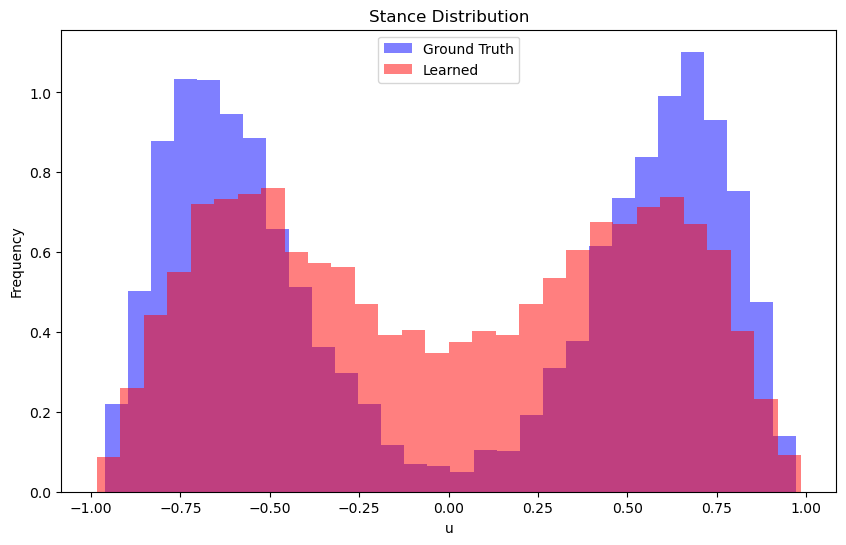

In [65]:
a = torch.exp(model.log_alpha).item()
b = torch.exp(model.log_beta).item()

samples = np.concatenate([
    stats.beta.rvs(a, b, size=5000), 
    stats.beta.rvs(b, a, size=5000)
]) * 2 - 1  

plt.figure(figsize=(10, 6))

plt.hist(u, bins=30, density=True, alpha=0.5, color='blue', label='Ground Truth')
plt.hist(samples, bins=30, density=True, alpha=0.5, color='red', label='Learned')

plt.title('Stance Distribution')
plt.xlabel('u')
plt.ylabel('Frequency')
plt.legend()

plt.show()
